# Signal Processing
- Quadricep    : Vastus Medialis (VM)
- Hamstring    : Semitendinosus (ST)
- Calve        : Gastrocnemius Medialis (GM)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import scipy as sp
from scipy.fft import fft
from scipy import signal
from scipy.integrate import quad

In [2]:
def get_index(data, index):
    if index < 0:
        return 0
    if index > data.size - 1:
        return 0
    return data[index]

# Remove mean EMG
def correct_mean(emg):
    return emg - np.mean(emg)

# EMG HPF Orde-2
def highpass(emg):
    outputHPF = np.zeros((len(emg)))
    for i in range(1, len(emg)-1):
        if i == 1 :
            outputHPF[i] = 0.9565*emg[i]
        elif i == 2:
            outputHPF[i] = 0.9565*emg[i]-1.9131*emg[i-1]+1.9112*outputHPF[i-1]
        else:
            outputHPF[i] = 0.9565*emg[i]-1.9131*emg[i-1]+0.9565*emg[i-2]+1.9112*outputHPF[i-1]-0.9150*outputHPF[i-2]
    return outputHPF

# EMG LPF Orde-2
def lowpass(emg):
    outputLPF = np.zeros((len(emg)))
    for i in range(1, len(emg)-1):
        if i == 1 :
            outputLPF[i] = 0.2929*emg[i]
        elif i == 2:
            outputLPF[i] = 0.2929*emg[i]+0.5858*emg[i-1]
        else:
            outputLPF[i] = 0.2929*emg[i]+0.5858*emg[i-1]+0.2929*emg[i-2]-0.1716*outputLPF[i-2]
    return outputLPF

# EMG rectified
def rectified(emg):
    return abs(emg)

# EMG MAV
def moving_average(emg, w=31):
    mask = np.ones((1, w)) / w
    mask = mask[0, :]
    emg_mav = np.convolve(emg, mask, 'same')

    return emg_mav

# EMG threshold
def threshold(emg, thres):
    max_value = np.max(emg)
    res = []
    for i in emg:
        res.append(1) if i > thres * max_value else res.append(0)
    return res

In [3]:
#EMG FFT
import numpy as np

def fft(signal):
    signal = np.asarray(signal, dtype=complex)
    N = signal.shape[0]
    if N <= 1:
        return signal
    even = fft(signal[::2])
    odd = fft(signal[1::2])
    factor = np.exp(-2j * np.pi * np.arange(N) / N)
    return np.concatenate([even + factor[:N//2] * odd, even + factor[N//2:] * odd])

def fftshift(x):
    N = len(x)
    return np.concatenate((x[:N//2], x[N//2:]))

def fftfreq(n, d=1.0):
    return np.fft.fftfreq(n, d)

def fftmagnitude(signal, sampling_frequency):
    N = len(signal)
    padded_size = int(2**(np.ceil(np.log2(N))))
    signal_padded = np.zeros(padded_size)
    signal_padded[:N] = signal
    X = fft(signal_padded)
    frequencies = abs(fftfreq(padded_size) * sampling_frequency)
    magnitude_spectrum = np.abs(fftshift(X))
    return frequencies, magnitude_spectrum


Feature Extraction
- Root Mean Square (RMS) 
- Simple Square Integral (SSI)
- Mean Absolute Value (MAV)
- Integrated EMG (IEMG)
- Peak Frequency (PKF)
- Mean Power (MNP)

In [4]:
# Time Domain Feature
#EMG RMS
def root_mean_square(emg):
    emg_array = np.array(emg)
    return np.sqrt(np.mean(emg_array ** 2))

#EMG SSI
def simple_square_integral(emg):
    emg_array = np.array(emg)
    return np.sum(emg_array ** 2)

#EMG MAV
def mean_absolute_value(emg):
    emg_array = np.array(emg)
    return np.mean(np.absolute(emg_array))

#EMG IEMG
def integrated_emg(emg):
    emg_array = np.array(emg)
    return np.sum(np.absolute(emg_array))

# Frequency Domain Feature
#EMG PKF
def peak_frequency(emg, fs):
    frequencies, magnitude_spectrum = fftmagnitude(emg, fs)
    peak_idx = np.argmax(magnitude_spectrum)
    peak_freq = frequencies[peak_idx]
    return peak_freq

#EMG MNP
def mean_power(emg, fs):
    sum1 = 0
    sum2 = 0
    frequencies, magnitude_spectrum = fftmagnitude(emg, fs)
    for n in range (round(len(emg)/2)):
        sum1 += ((n*fs/len(emg))*magnitude_spectrum[n])
        sum2 = (len(emg))
    return sum1 / sum2

In [5]:
#Extract Feature from each contraction
def extract_features(contraction):
    rms = root_mean_square(contraction)
    ssi = simple_square_integral(contraction)
    mav = mean_absolute_value(contraction)
    iemg = integrated_emg(contraction)
    
    fs = 2000
    
    pkf = peak_frequency(contraction,fs)
    mnp = mean_power(contraction,fs)
    return rms, ssi, mav, iemg, pkf, mnp

# Main Program

In [6]:
# Read EMG data
data = pd.read_csv("Dataset/Data_5.txt", sep=",", names=["emg1","emg2","emg3"])
data

,emg1,emg2,emg3
0,1.656850,3.295971,3.300000
1,1.660073,3.279048,3.300000
2,1.637509,3.275019,3.300000
3,1.636703,3.238755,3.300000
4,1.643150,3.237143,3.300000
...,...,...,...
26562,1.692308,1.789817,1.757582
26563,1.689890,1.760806,1.744689
26564,1.687473,1.738242,1.737436
26565,1.701978,1.763223,1.766447


In [7]:
# Variable
fs = 2000

emg1 = np.array(data.emg1) #Calve
emg2 = np.array(data.emg2) #Quadricep
emg3 = np.array(data.emg3) #Hamstring

n = np.arange(0, len(emg1))
time = n/675


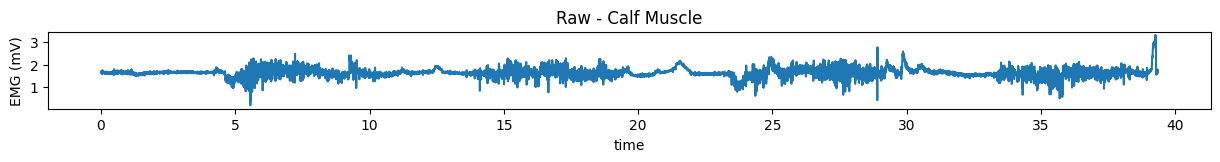

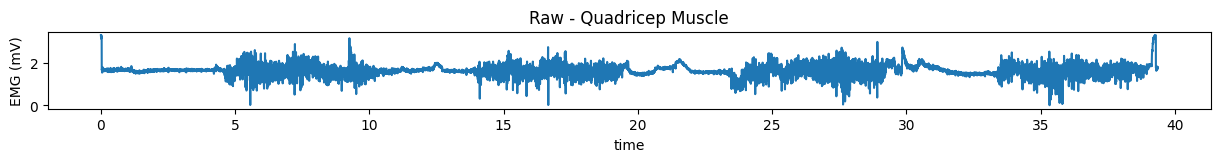

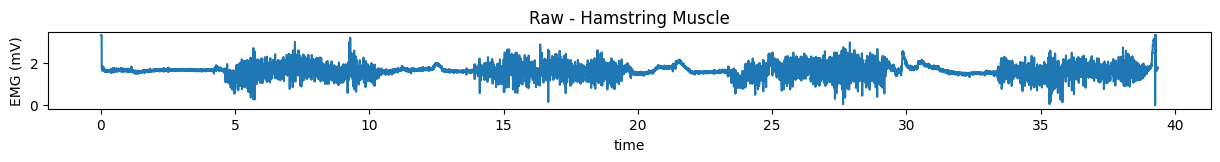

In [8]:
#Plot Raw Data
fig = plt.figure()
plt.plot(time, emg1)
plt.title('Raw - Calf Muscle')
plt.xlabel('time')
plt.ylabel('EMG (mV)')
fig.set_size_inches(w=15,h=1)

fig = plt.figure()
plt.plot(time,emg2)
plt.title('Raw - Quadricep Muscle')
plt.xlabel('time')
plt.ylabel('EMG (mV)')
fig.set_size_inches(w=15,h=1)

fig = plt.figure()
plt.plot(time,emg3)
plt.title('Raw - Hamstring Muscle')
plt.xlabel('time')
plt.ylabel('EMG (mV)')
fig.set_size_inches(w=15,h=1)

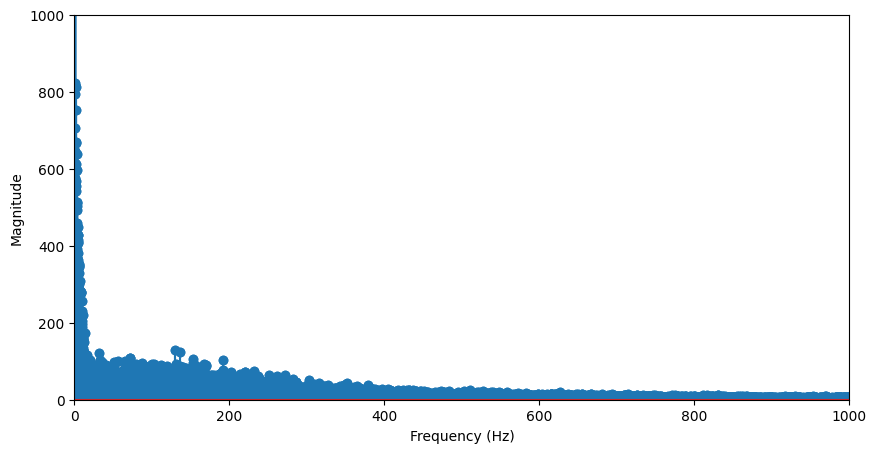

In [9]:
# Compute the FFT of the signal and its magnitude spectrum
fs = 2000
fs, emg1_fft = fftmagnitude(emg1, fs)

# Plot the magnitude spectrum of the FFT
plt.figure(figsize=((10,5)))
plt.stem(fs, emg1_fft)
# plt.plot(frequencies, magnitude_spectrum)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim([0, np.max(fs)])
plt.ylim([0, 1000])
plt.show()


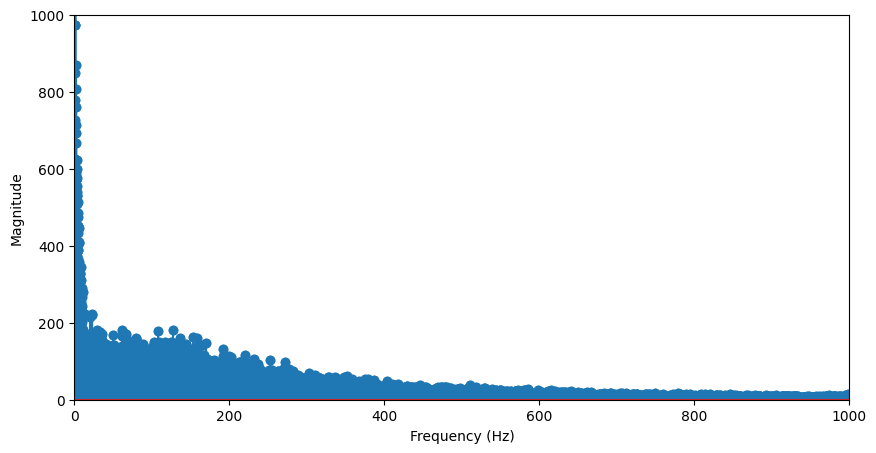

In [10]:
# Compute the FFT of the signal and its magnitude spectrum
fs = 2000
fs, emg2_fft = fftmagnitude(emg2, fs)

# # Plot the magnitude spectrum of the FFT
plt.figure(figsize=((10,5)))
plt.stem(fs, emg2_fft)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim([0, np.max(fs)])
plt.ylim([0, 1000])
plt.show()


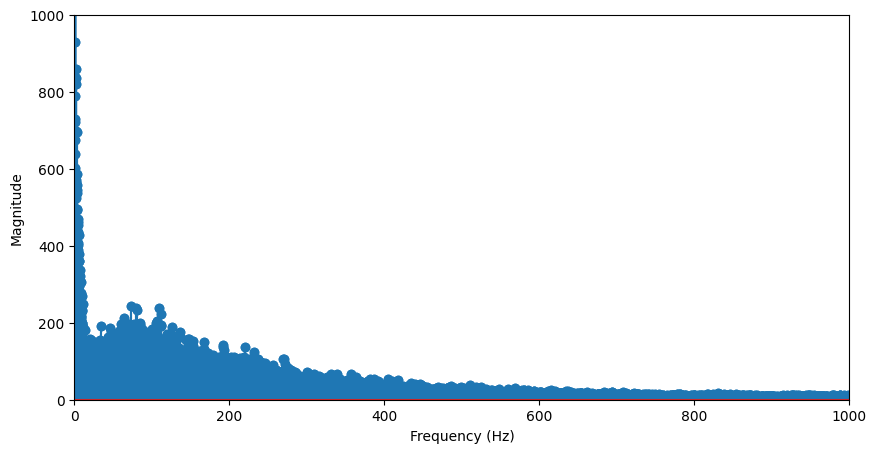

In [11]:
# Compute the FFT of the signal and its magnitude spectrum
fs = 2000
fs, emg3_fft = fftmagnitude(emg3, fs)

# Plot the magnitude spectrum of the FFT
plt.figure(figsize=((10,5)))
plt.stem(fs, emg3_fft)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim([0, np.max(fs)])
plt.ylim([0, 1000])
plt.show()

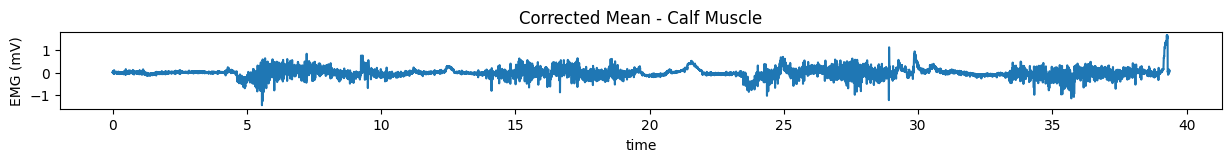

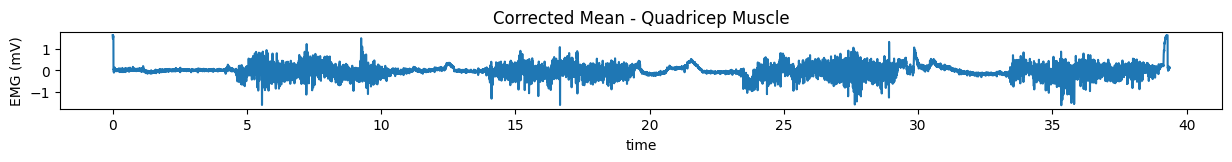

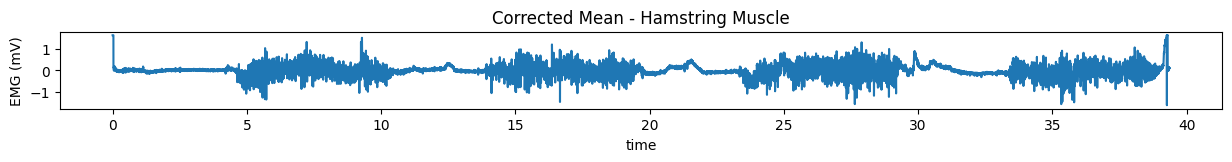

In [12]:
# Correct mean EMG
emg1_correct_mean = correct_mean(emg1) #emg1 - np.mean(emg1)
emg2_correct_mean = correct_mean(emg2) #emg2 - np.mean(emg2)
emg3_correct_mean = correct_mean(emg3) #emg3 - np.mean(emg3)

fig = plt.figure()
plt.plot(time, emg1_correct_mean)
plt.title('Corrected Mean - Calf Muscle')
plt.xlabel('time')
plt.ylabel('EMG (mV)')
fig.set_size_inches(w=15,h=1)

fig = plt.figure()
plt.plot(time, emg2_correct_mean)
plt.title('Corrected Mean - Quadricep Muscle')
plt.xlabel('time')
plt.ylabel('EMG (mV)')
fig.set_size_inches(w=15,h=1)

fig = plt.figure()
plt.plot(time, emg3_correct_mean)
plt.title('Corrected Mean - Hamstring Muscle')
plt.xlabel('time')
plt.ylabel('EMG (mV)')
fig.set_size_inches(w=15,h=1)


Text(0, 0.5, 'Magnitude')

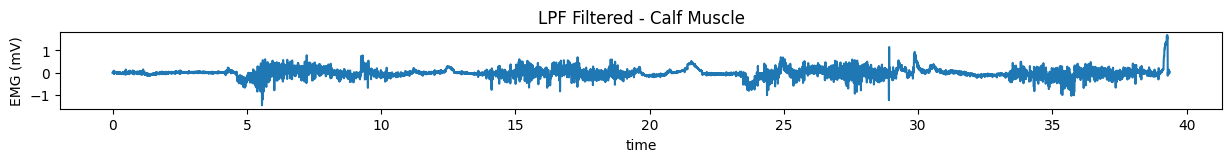

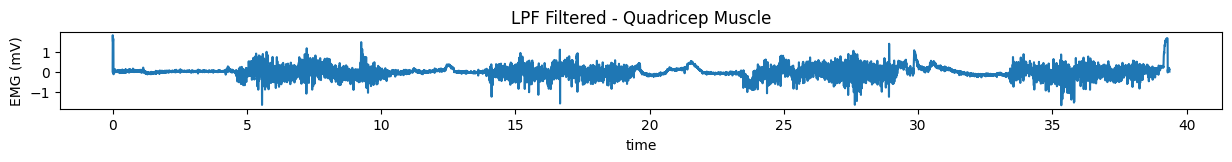

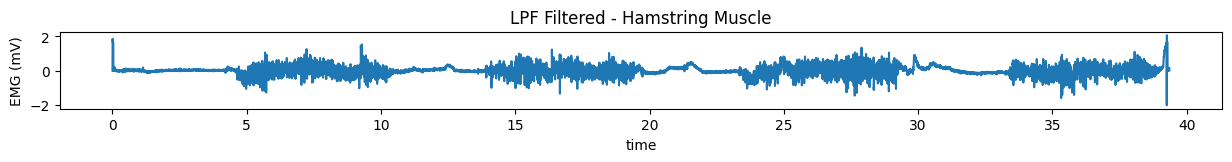

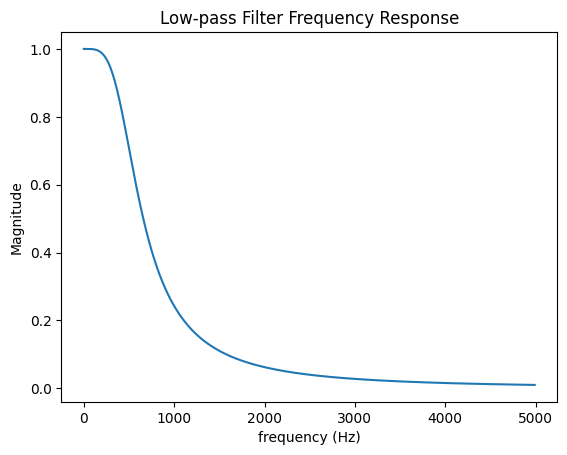

In [13]:
#LPF
emg1_lpf = lowpass(emg1_correct_mean)
emg2_lpf = lowpass(emg2_correct_mean)
emg3_lpf = lowpass(emg3_correct_mean)

fig = plt.figure()
plt.plot(time, emg1_lpf)
plt.title('LPF Filtered - Calf Muscle')
plt.xlabel('time')
plt.ylabel('EMG (mV)')
fig.set_size_inches(w=15,h=1)

fig = plt.figure()
plt.plot(time, emg2_lpf)
plt.title('LPF Filtered - Quadricep Muscle')
plt.xlabel('time')
plt.ylabel('EMG (mV)')
fig.set_size_inches(w=15,h=1)

fig = plt.figure()
plt.plot(time, emg3_lpf)
plt.title('LPF Filtered - Hamstring Muscle')
plt.xlabel('time')
plt.ylabel('EMG (mV)')
fig.set_size_inches(w=15,h=1)

# LPF Frequency Response
fc = 500
# n = 2
f = range(0,5000,10)
mag = []
for freq in f:
    mag.append(1/math.sqrt(1+(freq / fc)**(2*2)))

fig = plt.figure()
plt.plot(f, mag)
plt.title('Low-pass Filter Frequency Response')
plt.xlabel('frequency (Hz)')
plt.ylabel('Magnitude')

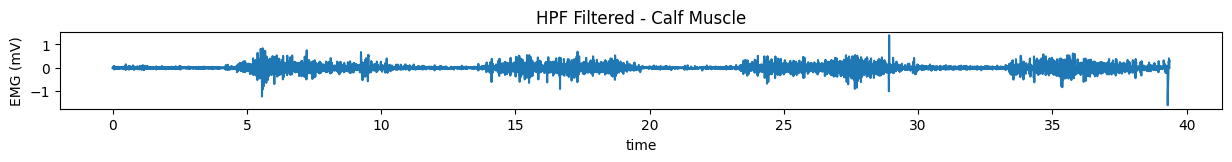

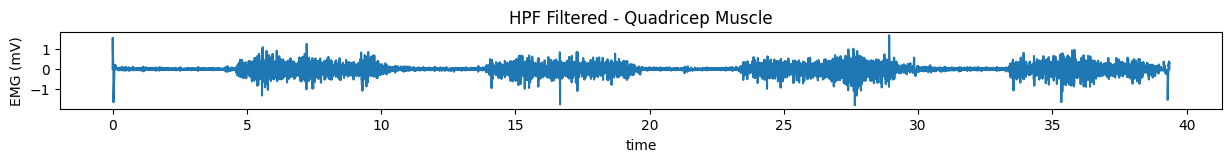

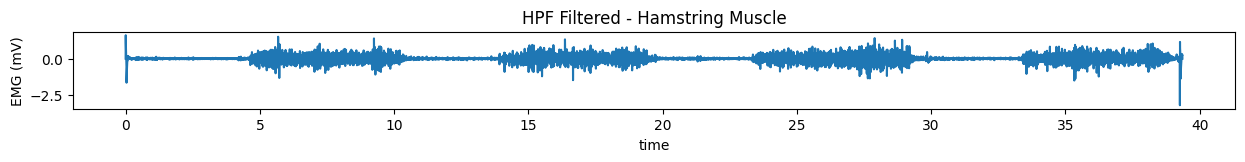

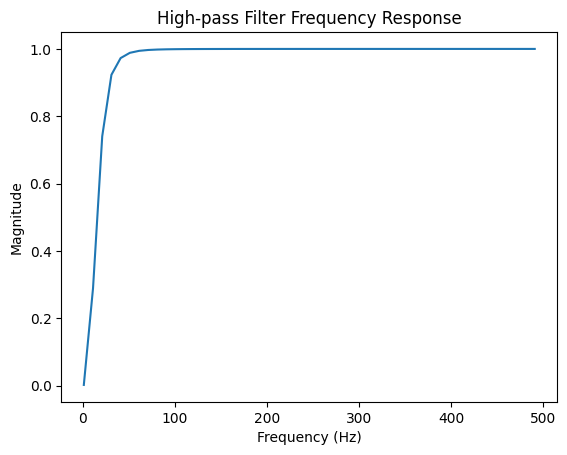

In [14]:
#HPF
emg1_hpf = highpass(emg1_lpf)
emg2_hpf = highpass(emg2_lpf)
emg3_hpf = highpass(emg3_lpf)

fig = plt.figure()
plt.plot(time, emg1_hpf)
plt.title('HPF Filtered - Calf Muscle')
plt.xlabel('time')
plt.ylabel('EMG (mV)')
fig.set_size_inches(w=15,h=1)

fig = plt.figure()
plt.plot(time, emg2_hpf)
plt.title('HPF Filtered - Quadricep Muscle')
plt.xlabel('time')
plt.ylabel('EMG (mV)')
fig.set_size_inches(w=15,h=1)

fig = plt.figure()
plt.plot(time, emg3_hpf)
plt.title('HPF Filtered - Hamstring Muscle')
plt.xlabel('time')
plt.ylabel('EMG (mV)')
fig.set_size_inches(w=15,h=1)

fc = 20  # Cutoff frequency
# n = 2      # Filter order
# Create frequency values
f = range(1, 500, 10)  # Frequency values from 0 to 5000 Hz

# Calculate magnitude response for each frequency
mag = []
for freq in f:
    mag.append(1/math.sqrt(1+(fc / freq)**(2*2)))

# Plot frequency response
fig = plt.figure()
plt.plot(f, mag)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('High-pass Filter Frequency Response')
plt.show()


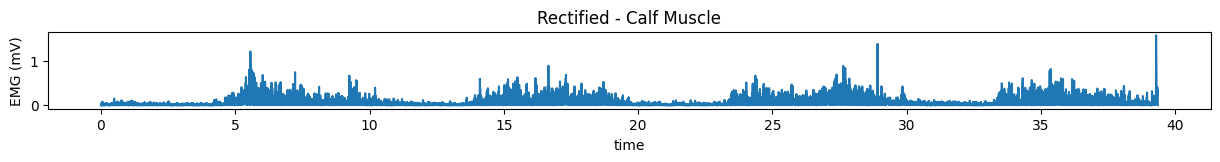

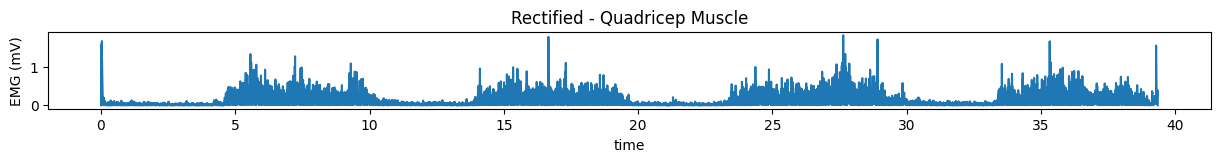

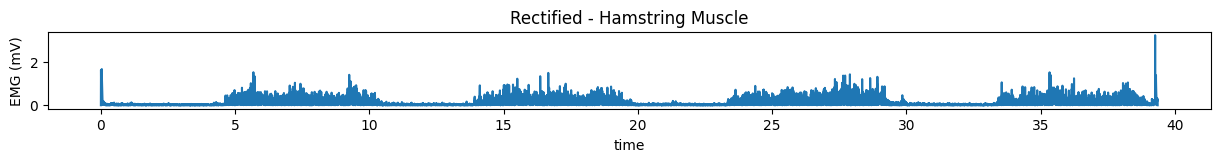

In [15]:
# Rectified EMG
emg1_rectified = rectified(emg1_hpf)
emg2_rectified = rectified(emg2_hpf)
emg3_rectified = rectified(emg3_hpf)

fig = plt.figure()
plt.plot(time, emg1_rectified)
plt.title('Rectified - Calf Muscle')
plt.xlabel('time')
plt.ylabel('EMG (mV)')
fig.set_size_inches(w=15,h=1)

fig = plt.figure()
plt.plot(time, emg2_rectified)
plt.title('Rectified - Quadricep Muscle')
plt.xlabel('time')
plt.ylabel('EMG (mV)')
fig.set_size_inches(w=15,h=1)

fig = plt.figure()
plt.plot(time, emg3_rectified)
plt.title('Rectified - Hamstring Muscle')
plt.xlabel('time')
plt.ylabel('EMG (mV)')
fig.set_size_inches(w=15,h=1)


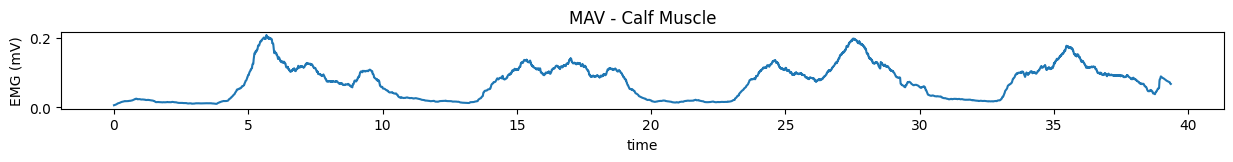

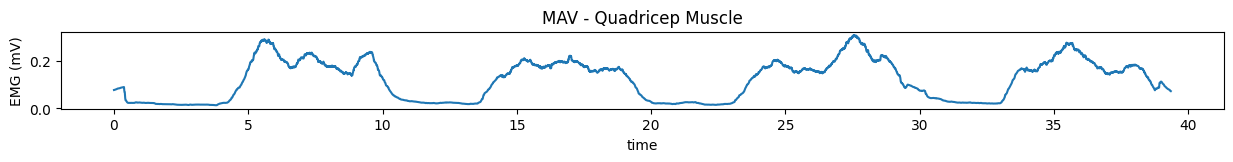

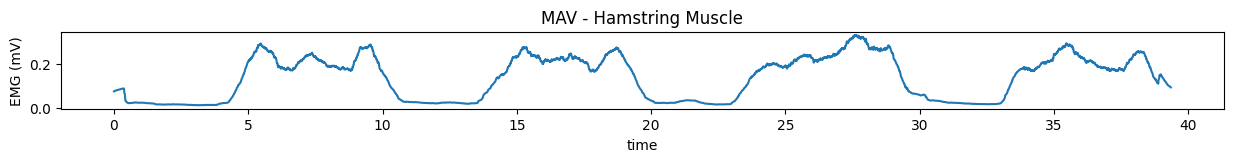

In [16]:
# EMG MAV
emg1_mav = moving_average(emg1_rectified, 500)
emg2_mav = moving_average(emg2_rectified, 500)
emg3_mav = moving_average(emg3_rectified, 500)

fig = plt.figure()
plt.plot(time, emg1_mav[:len(time)])
plt.title('MAV - Calf Muscle')
plt.xlabel('time')
plt.ylabel('EMG (mV)')
fig.set_size_inches(w=15,h=1)

fig = plt.figure()
plt.plot(time, emg2_mav[:len(time)])
plt.title('MAV - Quadricep Muscle')
plt.xlabel('time')
plt.ylabel('EMG (mV)')
fig.set_size_inches(w=15,h=1)

fig = plt.figure()
plt.plot(time, emg3_mav[:len(time)])
plt.title('MAV - Hamstring Muscle')
plt.xlabel('time')
plt.ylabel('EMG (mV)')
fig.set_size_inches(w=15,h=1)

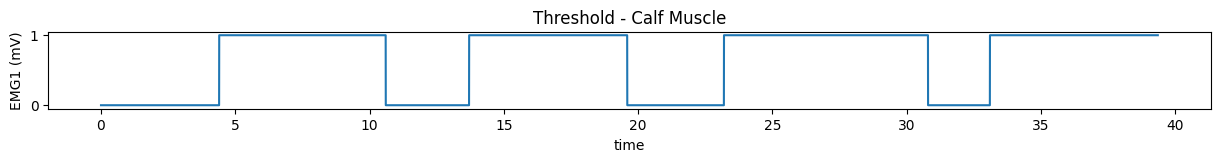

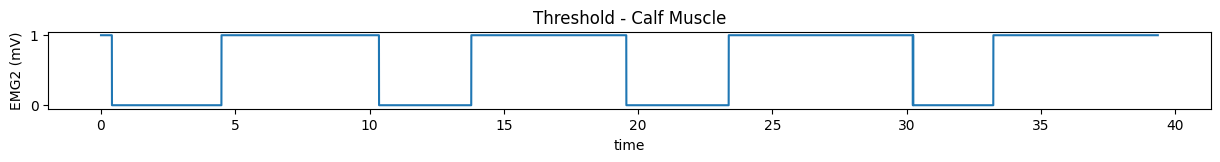

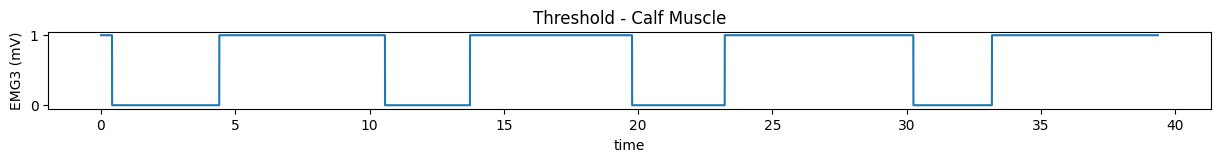

In [17]:
# EMG threshold
emg1_threshold = threshold(emg1_mav, 0.15)
emg2_threshold = threshold(emg2_mav, 0.2)
emg3_threshold = threshold(emg3_mav, 0.15)

fig = plt.figure()
plt.plot(time, emg1_threshold[:len(time)])
plt.title('Threshold - Calf Muscle')
plt.xlabel('time')
plt.ylabel('EMG1 (mV)')
fig.set_size_inches(w=15,h=1)

fig = plt.figure()
plt.plot(time, emg2_threshold[:len(time)])
plt.title('Threshold - Calf Muscle')
plt.xlabel('time')
plt.ylabel('EMG2 (mV)')
fig.set_size_inches(w=15,h=1)

fig = plt.figure()
plt.plot(time, emg3_threshold[:len(time)])
plt.title('Threshold - Calf Muscle')
plt.xlabel('time')
plt.ylabel('EMG3 (mV)')
fig.set_size_inches(w=15,h=1)

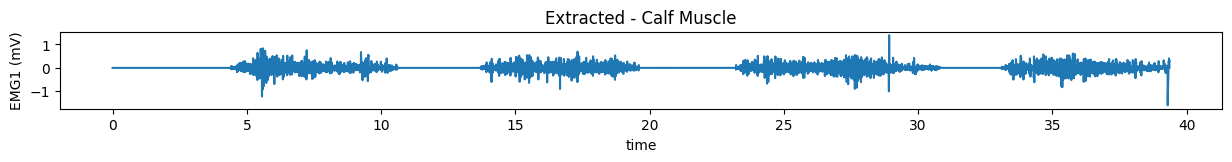

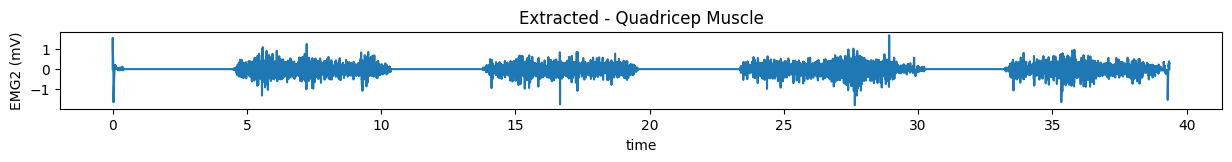

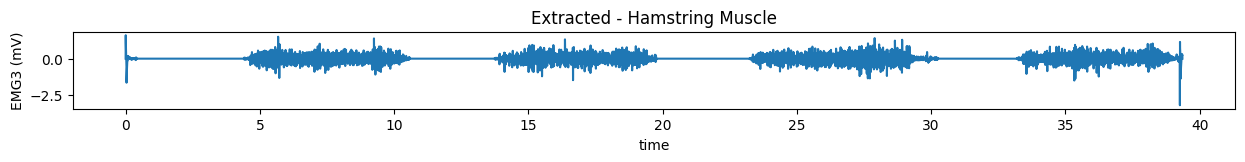

In [18]:
# EMG Extract
emg1_extract = emg1_threshold[:len(time)] * emg1_hpf
emg2_extract = emg2_threshold[:len(time)] * emg2_hpf
emg3_extract = emg3_threshold[:len(time)] * emg3_hpf

fig = plt.figure()
plt.plot(time, emg1_extract)
plt.title('Extracted - Calf Muscle')
plt.xlabel('time')
plt.ylabel('EMG1 (mV)')
fig.set_size_inches(w=15,h=1)

fig = plt.figure()
plt.plot(time, emg2_extract)
plt.title('Extracted - Quadricep Muscle')
plt.xlabel('time')
plt.ylabel('EMG2 (mV)')
fig.set_size_inches(w=15,h=1)

fig = plt.figure()
plt.plot(time, emg3_extract)
plt.title('Extracted - Hamstring Muscle')
plt.xlabel('time')
plt.ylabel('EMG3 (mV)')
fig.set_size_inches(w=15,h=1)


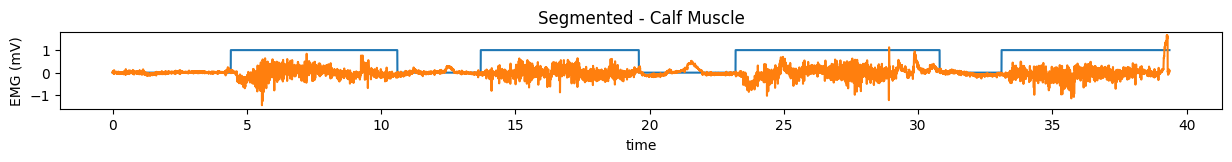

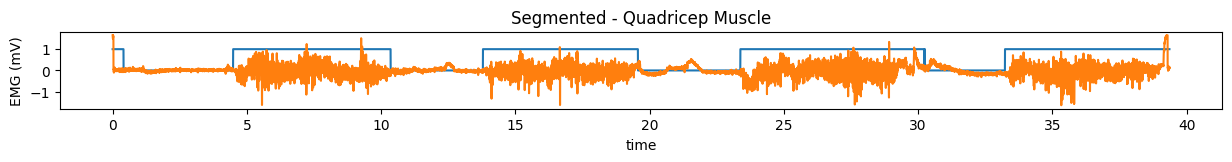

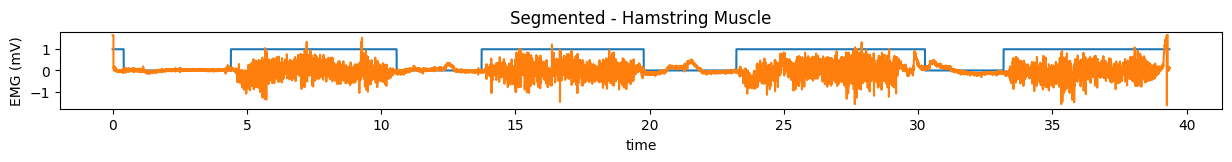

In [19]:
max1_segment = np.max(emg1_extract)
max2_segment = np.max(emg2_extract)
max3_segment = np.max(emg3_extract)

fig = plt.figure()
plt.plot(time, emg1_threshold[:len(time)])
plt.plot(time, emg1_correct_mean)
plt.title('Segmented - Calf Muscle')
plt.xlabel('time')
plt.ylabel('EMG (mV)')
fig.set_size_inches(w=15,h=1)

fig = plt.figure()
plt.plot(time, emg2_threshold[:len(time)])
plt.plot(time, emg2_correct_mean)
plt.title('Segmented - Quadricep Muscle')
plt.xlabel('time')
plt.ylabel('EMG (mV)')
fig.set_size_inches(w=15,h=1)

fig = plt.figure()
plt.plot(time, emg3_threshold[:len(time)])
plt.plot(time, emg3_correct_mean)
plt.title('Segmented - Hamstring Muscle')
plt.xlabel('time')
plt.ylabel('EMG (mV)')
fig.set_size_inches(w=15,h=1)


In [20]:
# Extract Contraction EMG 1 - Calve
emg1_contractions = []
emg1_contraction_start = False
for i in range(len(emg1_extract)):
    if emg1_extract[i] != 0 and not emg1_contraction_start:
        emg1_contraction_start = True
        emg1_contraction = [emg1_extract[i]]
    elif emg1_extract[i] != 0 and emg1_contraction_start:
        emg1_contraction.append(emg1_extract[i])
    elif emg1_extract[i] == 0 and emg1_contraction_start:
        emg1_contraction_start = False
        # emg1_contractions.append(emg1_contraction)
        if len(emg1_contraction) >= 1500:  # Add condition for minimum contraction length
            emg1_contractions.append(emg1_contraction)

emg1_contraction_count = len(emg1_contractions)
print("Total emg1_contractions:", emg1_contraction_count)

# Extract Contraction EMG 2 - Quadricep
emg2_contractions = []
emg2_contraction_start = False
for i in range(len(emg2_extract)):
    if emg2_extract[i] != 0 and not emg2_contraction_start:
        emg2_contraction_start = True
        emg2_contraction = [emg2_extract[i]]
    elif emg2_extract[i] != 0 and emg2_contraction_start:
        emg2_contraction.append(emg2_extract[i])
    elif emg2_extract[i] == 0 and emg2_contraction_start:
        emg2_contraction_start = False
        # emg2_contractions.append(emg2_contraction)
        if len(emg2_contraction) >= 1500:  # Add condition for minimum contraction length
            emg2_contractions.append(emg2_contraction)

emg2_contraction_count = len(emg2_contractions)
print("Total emg2_contractions:", emg2_contraction_count)

# Extract Contraction EMG 3 - Hamstring
emg3_contractions = []
emg3_contraction_start = False
for i in range(len(emg3_extract)):
    if emg3_extract[i] != 0 and not emg3_contraction_start:
        emg3_contraction_start = True
        emg3_contraction = [emg3_extract[i]]
    elif emg3_extract[i] != 0 and emg3_contraction_start:
        emg3_contraction.append(emg3_extract[i])
    elif emg3_extract[i] == 0 and emg3_contraction_start:
        emg3_contraction_start = False
        # emg3_contractions.append(emg3_contraction)
        if len(emg3_contraction) >= 1500:  # Add condition for minimum contraction length
            emg3_contractions.append(emg3_contraction)

emg3_contraction_count = len(emg3_contractions)
print("Total emg3_contractions:", emg3_contraction_count)


Total emg1_contractions: 4
Total emg2_contractions: 4
Total emg3_contractions: 4


## Signal After Threshold Procedure

In [50]:
# Perform feature extraction on each emg1_contraction
emg1_features = []
for contraction in emg1_contractions:
    features = extract_features(contraction)
    emg1_features.append(features)

# Perform feature extraction on each emg2_contraction
emg2_features = []
for contraction in emg2_contractions:
    features = extract_features(contraction)
    emg2_features.append(features)

# Perform feature extraction on each emg3_contraction
emg3_features = []
for contraction in emg3_contractions:
    features = extract_features(contraction)
    emg3_features.append(features)


In [51]:
# Print the extracted features for each contraction
print("EMG 1 Features:")
for features in emg1_features:
    print(features)

print("EMG 2 Features:")
for features in emg2_features:
    print(features)

print("EMG 3 Features:")
for features in emg3_features:
    print(features)

EMG 1 Features:
(0.15122671120170733, 95.7546726233638, 0.1002881481443061, 419.90647628020963, 108.642578125, 1910.7113703121045)
(0.13968416438275885, 77.55887147275564, 0.09865467145371577, 392.1523190285202, 112.3046875, 564.297950157495)
(0.1467874181621354, 110.53378165051971, 0.10243339669526139, 525.4833250466909, 79.345703125, 1624.4491713115667)
(0.15168923858178487, 97.12362755352291, 0.103113338288583, 435.24140091610883, 85.9375, 1872.36011500344)
EMG 2 Features:
(0.25580487761241993, 259.1270962248084, 0.19055334743541624, 754.5912558442483, 59.5703125, 994.0700456162566)
(0.22115736819897844, 190.60453613939814, 0.16356520354875853, 637.413598229512, 49.8046875, 922.5334158822932)
(0.24417695098981418, 275.8131455837995, 0.17696484169290436, 818.6393576713756, 79.345703125, 2935.0567229348744)
(0.2388802071095572, 235.95862009689498, 0.174698490571217, 722.3782585119823, 77.1484375, 3010.233663339369)
EMG 3 Features:
(0.2668388246946956, 296.631524546284, 0.2010050508410

In [ ]:
emg_features = [emg1_features, emg2_features, emg3_features]

file_path = "Features/Data_DOMS_5_EMG1.txt"

with open(file_path, 'w') as file:
    for emg_idx, emg in enumerate(emg_features, start=1):
        file.write(f"EMG {emg_idx} Features:\n")
        for iteration, features in enumerate(emg, start=1):
            feature_string = ', '.join(str(feature) for feature in features)
            file.write(f"{feature_string}\n")
        file.write('\n')

print(f"The EMG features have been written to '{file_path}'.")

## Check Frequency After Filter

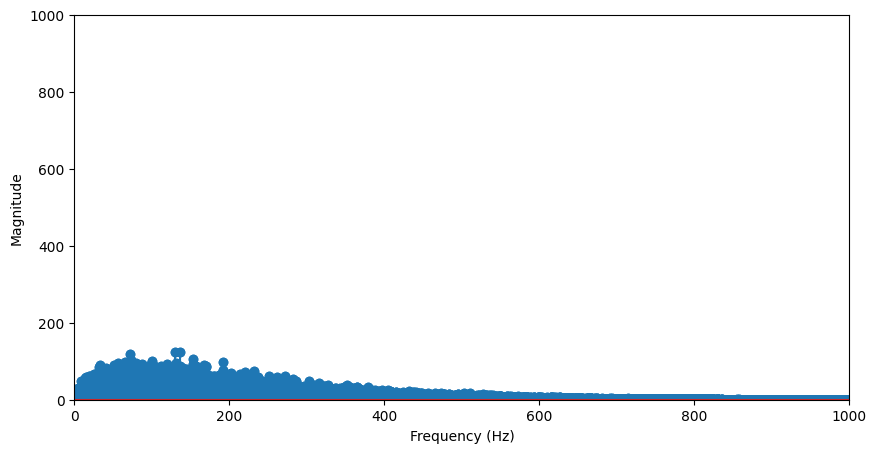

In [53]:
# Compute the FFT of the signal and its magnitude spectrum
fs = 2000
fs, emg1_fft = fftmagnitude(emg1_hpf, fs)

# Plot the magnitude spectrum of the FFT
plt.figure(figsize=((10,5)))
plt.stem(fs, emg1_fft)
# plt.plot(frequencies, magnitude_spectrum)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim([0, np.max(fs)])
plt.ylim([0, 1000])
plt.show()


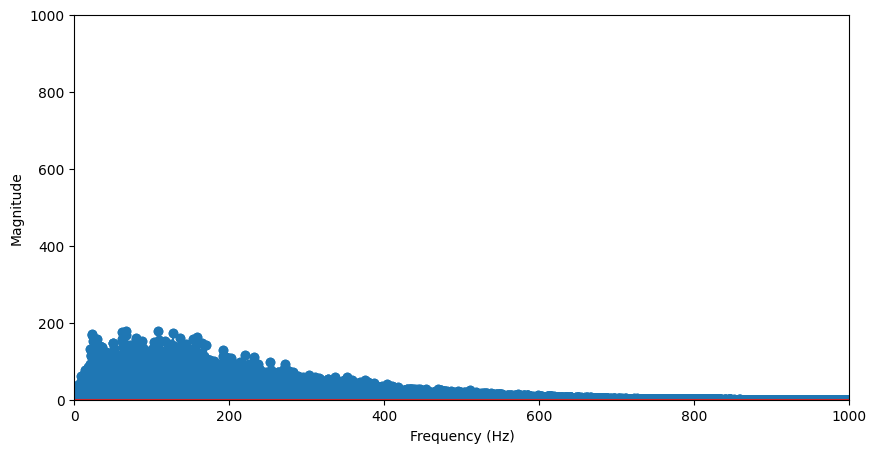

In [54]:
# Compute the FFT of the signal and its magnitude spectrum
fs = 2000
fs, emg2_fft = fftmagnitude(emg2_hpf, fs)

# # Plot the magnitude spectrum of the FFT
plt.figure(figsize=((10,5)))
plt.stem(fs, emg2_fft)
# plt.plot(frequencies, magnitude_spectrum)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim([0, np.max(fs)])
plt.ylim([0, 1000])
plt.show()


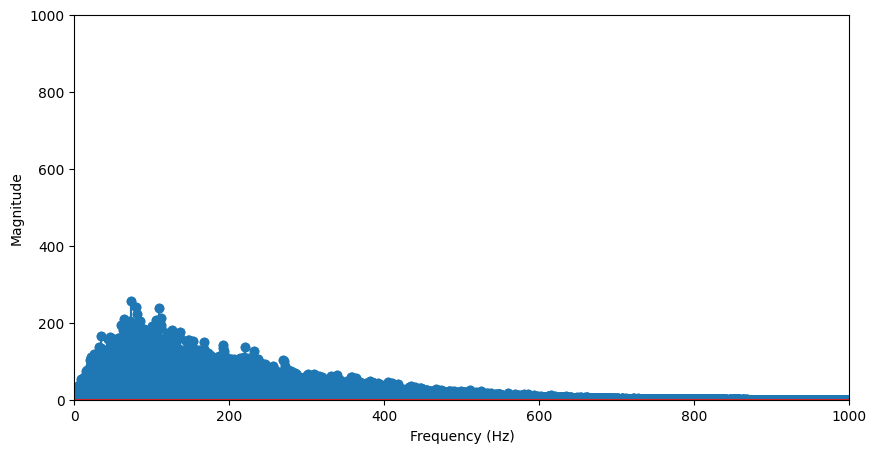

In [55]:
# Compute the FFT of the signal and its magnitude spectrum
fs = 2000
fs, emg3_fft = fftmagnitude(emg3_hpf, fs)

# Plot the magnitude spectrum of the FFT
plt.figure(figsize=((10,5)))
plt.stem(fs, emg3_fft)
# plt.plot(frequencies, magnitude_spectrum)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim([0, np.max(fs)])
plt.ylim([0, 1000])
plt.show()